# Empirical Cross Covariance

Note that the analysis below assumes realizations are independent across time. This is a bad assumption, but should still provide a reasonable approximation.

In [1]:
import sys
sys.path.insert(0, "../src")

In [2]:
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt

import krige_tools

In [3]:
# collect gridded dataset, standardize, and establish a common domain
df_grid = (
    pd.DataFrame(krige_tools.land_grid(res=5))
    .rename(columns={0:"lat", 1:"lon"})
    .assign(land=lambda x:1)
    .set_index(["lon", "lat"])
)

def standardize_da(da):
    return (da - da.mean(dim="time")) / da.std(dim="time")

with xr.open_dataset("../data/exp_pro/OCO2_5deg_monthly.nc") as ds:
    ds = ds[["sif", "xco2"]]
    ds["sif"] = standardize_da(ds.sif)
    ds["xco2"] = standardize_da(ds.xco2)

df = ds.to_dataframe().join(df_grid).dropna(subset=["land"]).reset_index()
df["lat_lon"] = df[["lat", "lon"]].apply(tuple, axis=1)
df

/home/jj829/sif-data-fusion/conda-env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/jj829/sif-data-fusion/conda-env/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1665: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)


,lat,lon,time,sif,xco2,land,lat_lon
0,-87.5,-177.5,2014-09-01,NaN,NaN,1.0,"(-87.5, -177.5)"
1,-87.5,-177.5,2014-10-01,NaN,NaN,1.0,"(-87.5, -177.5)"
2,-87.5,-177.5,2014-11-01,-0.354729,NaN,1.0,"(-87.5, -177.5)"
3,-87.5,-177.5,2014-12-01,-2.333229,NaN,1.0,"(-87.5, -177.5)"
4,-87.5,-177.5,2015-01-01,NaN,NaN,1.0,"(-87.5, -177.5)"
...,...,...,...,...,...,...,...
92770,82.5,97.5,2020-07-01,NaN,NaN,1.0,"(82.5, 97.5)"
92771,82.5,97.5,2020-08-01,0.382417,NaN,1.0,"(82.5, 97.5)"
92772,82.5,97.5,2020-09-01,NaN,NaN,1.0,"(82.5, 97.5)"
92773,82.5,97.5,2020-10-01,NaN,NaN,1.0,"(82.5, 97.5)"


In [4]:
df_sif = df.dropna(subset=["sif"]).pivot(index="lat_lon", columns="time", values="sif")
df_xco2 = df.dropna(subset=["xco2"]).pivot(index="lat_lon", columns="time", values="xco2")

In [5]:
def outer_product(x1, x2):
    return np.outer(x1 - np.nanmean(x1), x2 - np.nanmean(x2))

def empirical_cross_cov(X1, X2, offset=0):
    # Cross covariance (lag=offset) of two spatio-temporal matrices with locations in rows and time along columns
    # Cressie and Wikle, eq (5.4)
    assert X1.shape[1] == X2.shape[1]
    return np.nanmean(np.stack([outer_product(X1[:, i+offset], X2[:, i]) for i in range(X1.shape[1] - offset)], axis=2), axis=2)

xco2_cov = empirical_cross_cov(df_xco2.values, df_xco2.values)
sif_cov = empirical_cross_cov(df_sif.values, df_sif.values)
xcov = empirical_cross_cov(df_xco2.values, df_sif.values, offset=2)

/home/jj829/sif-data-fusion/conda-env/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: Mean of empty slice
  


In [21]:
def get_diag_std(C0):
    return np.diag(np.float_power(np.diag(C0), -0.5))

xco2_diag = get_diag_std(xco2_cov)
sif_diag = get_diag_std(sif_cov)

In [22]:
xcorr = np.matmul(xco2_diag, np.matmul(xcov, sif_diag))

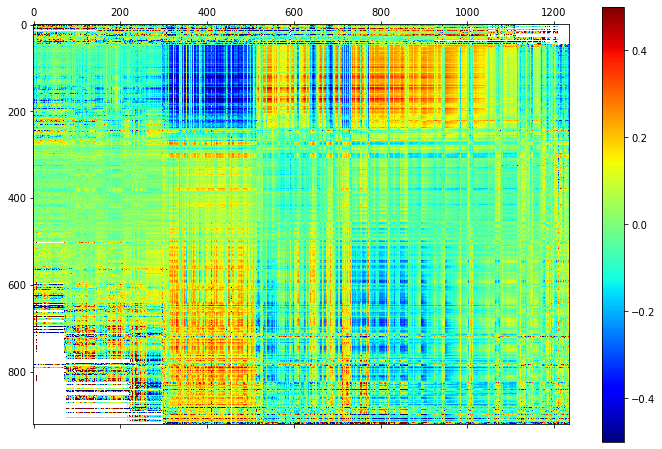

In [24]:
# NOTE: The cross-covariance is not symmetric, but there's no reason it should be...
# fig, ax = plt.subplots(1, 2, figsize=(24,12))
# cax0 = ax[0].matshow(xco2_diag @ xcov, cmap="jet", vmin=-0.5, vmax=0.5)
# cax1 = ax[1].matshow(sif_diag, cmap="jet", vmin=-0.5, vmax=0.5)
# fig.colorbar(cax0)

fig, ax = plt.subplots(figsize=(12,8))
cax = ax.matshow(xcov, cmap="jet", vmin=-0.5, vmax=0.5)
fig.colorbar(cax);

In [6]:
# get the distance matrix

In [7]:
# plot values in covariance matrix as a function of distance

In [ ]:
# NEXT: work on eqn 5.7 (just need to sort out pairs within time lag)
# This is the function of distance we will fit parmeters to